# Modeling

Since this is a regression problem, we will be using the following models:
 - RandomForestRegressor
 - Lasso
 - XGBoost
 - LinearRegression
 - OLS

We will perform hyperparameter tunning for at least three of these models and pick the best performing model.

Let us import all the necessary packages:

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Lasso, LinearRegression
import xgboost as xg
from sklearn.feature_selection import SelectKBest, f_classif
import statsmodels.api as sm
import pickle
import datetime

In [2]:
plt.style.use('ggplot')
sns.set_palette(palette='Set1')
sns.set_style("darkgrid")

Read in our data:

In [3]:
df = pd.read_csv('Modeling_data.csv')

In [4]:
df.info(verbose=True,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11440 entries, 0 to 11439
Data columns (total 124 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Unnamed: 0                          11440 non-null  int64  
 1   R                                   11440 non-null  float64
 2   Python                              11440 non-null  float64
 3   Julia                               11440 non-null  float64
 4   SQL                                 11440 non-null  float64
 5   Scala                               11440 non-null  float64
 6   JavaScript                          11440 non-null  float64
 7   Title_Machine                       11440 non-null  float64
 8   Title_Deep                          11440 non-null  float64
 9   Title_Analyst                       11440 non-null  float64
 10  Title_Engineer                      11440 non-null  float64
 11  Title_Scientist                     1144

In [5]:
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,R,Python,Julia,SQL,Scala,JavaScript,Title_Machine,Title_Deep,Title_Analyst,Title_Engineer,...,Southwest Research Institute,Leidos,Booz Allen Hamilton Inc,UC San Diego,Kforce Technology Staffing,Google,CyberCoders,Guidehouse,In_Headquarters,Avg_Salary
0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0.0,146000.0
1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1.0,146000.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1.0,146000.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1.0,146000.0
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1.0,146000.0


Split our train and test data:

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Avg_Salary', axis=1), df.Avg_Salary, test_size=0.30, random_state=42)

# RandomForest
Here we will apply the RandomForestRegressor. We will start with a simple, raw regressor and see where we stand:

In [7]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train,y_train)
rf.score(X_test,y_test)

0.3400718066247146

In [8]:
mean_absolute_error(y_test, rf.predict(X_test))

21491.650883075352

Our simple regressor is giving us an error of +- $21491. Let us see if we can improve the error with hyperparameter tunnig:

# Run the best estimator from this RandomizedSearch below with n_estimators = 1000 and see if the model improves.

In [9]:
rf_params = {'bootstrap': [True, False],
               'max_depth': [10, 50, None], #choose 10, 50, 100, none / this overfits
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [5,50,100, 500], #this overfits
               'n_estimators': [100]}
rf_grid = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid = GridSearchCV(rf_grid,rf_params, cv = 3, verbose=2, n_jobs = -1)

In [10]:
rf_grid.fit(X_train,y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   16.9s finished


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 50, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 50, 100, 500],
                         'n_estimators': [100]},
             verbose=2)

In [11]:
print(rf_grid.best_params_)
print(rf_grid.best_estimator_.score(X_test,y_test))
print(rf_grid.best_estimator_)

{'bootstrap': True, 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 5, 'n_estimators': 100}
0.40694808176414854
RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                      random_state=42)


In [12]:
mean_absolute_error(y_test, rf_grid.best_estimator_.predict(X_test))

20956.756584469742

Our model improved a little bit. Let's see our feature importance:

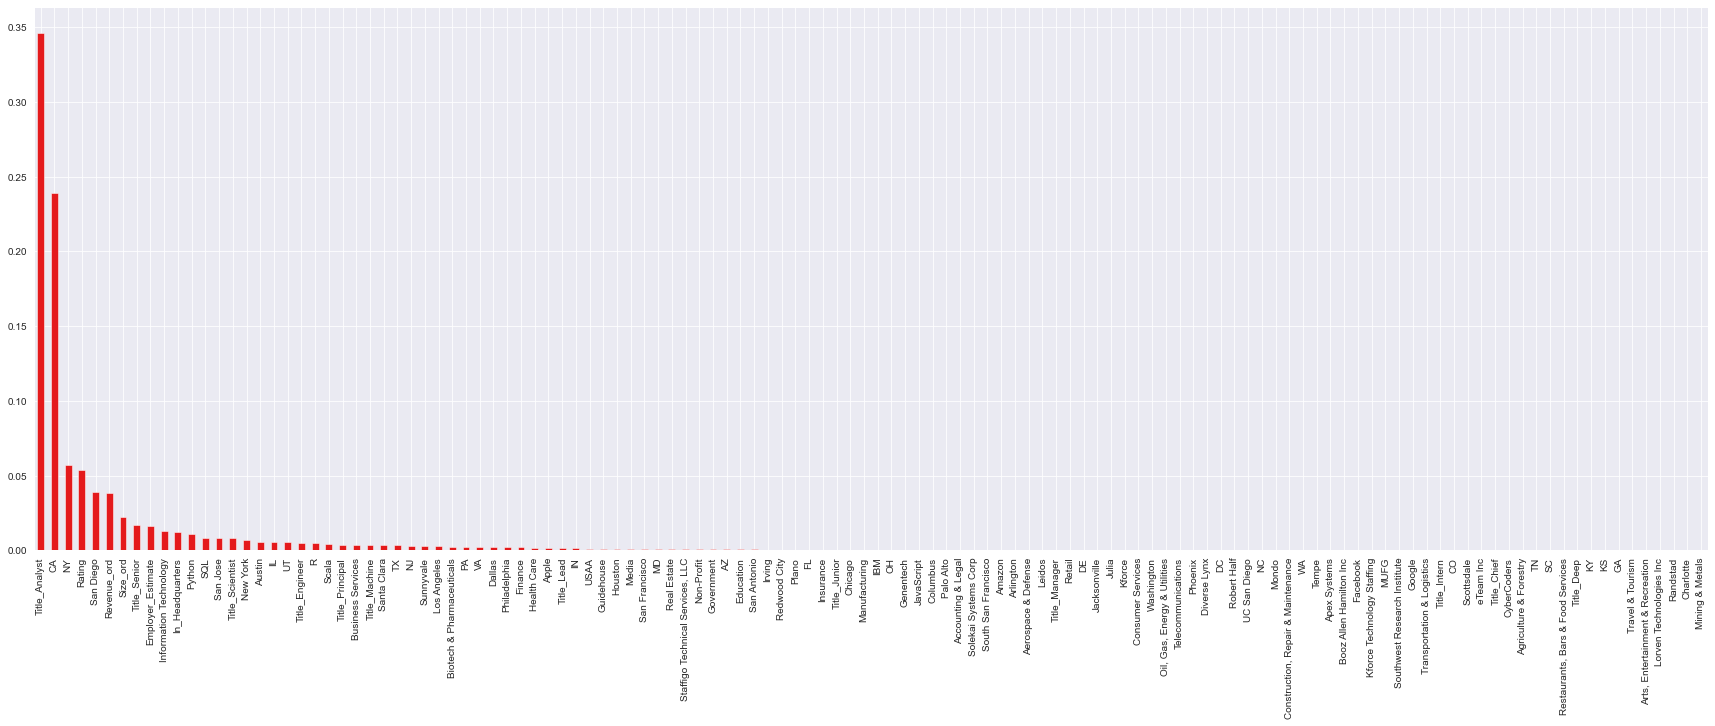

In [13]:
plt.figure(figsize=(30,10))
pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)[:200].plot(kind='bar')
plt.show()

Let's try another RandomForestRegressor using our best parameters but increasing n_estimators to see if we can improve our model a little more:

In [14]:
rf_n = RandomForestRegressor(n_jobs=-1, random_state=42, bootstrap= True, max_depth= 10, max_features= 'auto', min_samples_leaf= 5, n_estimators= 1000)
rf_n.fit(X_train,y_train)
rf_n.score(X_test,y_test)

0.4074619289198107

In [15]:
mean_absolute_error(y_test, rf_n.predict(X_test))

20941.39341044452

Okay, $15 more accurate.

Now let us see if dropping the variables with no importance makes a differece:

In [16]:
pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns).sort_values(ascending=False)[pd.Series(rf_grid.best_estimator_.feature_importances_, index=X_train.columns)==0].index

Index(['eTeam Inc', 'Title_Chief', 'CyberCoders', 'Agriculture & Forestry',
       'TN', 'SC', 'Restaurants, Bars & Food Services', 'Title_Deep', 'KY',
       'KS', 'GA', 'Travel & Tourism', 'Arts, Entertainment & Recreation',
       'Lorven Technologies Inc', 'Randstad', 'Charlotte', 'Mining & Metals'],
      dtype='object')

In [17]:
df_clean = df.copy()
df_clean.drop(columns = ['eTeam Inc', 'Title_Chief', 'CyberCoders', 'Agriculture & Forestry',
       'TN', 'SC', 'Restaurants, Bars & Food Services', 'Title_Deep', 'KY',
       'KS', 'GA', 'Travel & Tourism', 'Arts, Entertainment & Recreation',
       'Lorven Technologies Inc', 'Randstad', 'Charlotte', 'Mining & Metals'], inplace=True)

In [18]:
X_train_clean, X_test_clean, y_train_clean, y_test_clean = train_test_split(df_clean.drop('Avg_Salary', axis=1), df_clean.Avg_Salary, test_size=0.30, random_state=42)

In [19]:
rf_clean = RandomForestRegressor(n_jobs=-1, random_state=42, bootstrap= True, max_depth= 10, max_features= 'auto', min_samples_leaf= 5, n_estimators= 1000)
rf_clean.fit(X_train_clean,y_train_clean)
rf_clean.score(X_test_clean,y_test_clean)

0.4074484391071409

In [20]:
mean_absolute_error(y_test_clean, rf_clean.predict(X_test_clean))

20941.48056170549

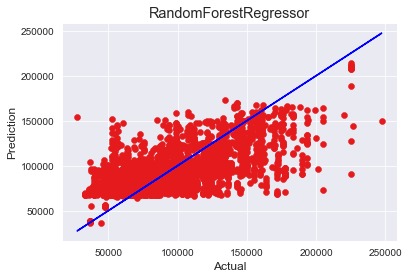

In [21]:
plt.scatter(y_test, rf_n.predict(X_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('RandomForestRegressor')

plt.show()

No difference whatsoever. 

So far the best model has a MAE of $20941.

Let's try a different model:

# Lasso

In [22]:
lasso = Lasso(alpha=0.5)
lasso.fit(X_train,y_train)
mean_absolute_error(y_test, lasso.predict(X_test))

21744.25522691714

In [23]:
lasso_params = {'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 1]}
lasso_grid = Lasso()
lasso_grid = GridSearchCV(lasso_grid,lasso_params, cv = 3, verbose=2, n_jobs = -1)
lasso_grid.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  18 | elapsed:    4.7s remaining:    7.4s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    5.0s finished


GridSearchCV(cv=3, estimator=Lasso(), n_jobs=-1,
             param_grid={'alpha': [0.01, 0.05, 0.1, 0.3, 0.5, 1]}, verbose=2)

In [24]:
print(lasso_grid.best_params_)
print(lasso_grid.best_estimator_.score(X_test,y_test))
print(lasso_grid.best_estimator_)

{'alpha': 1}
0.3827107412261298
Lasso(alpha=1)


In [25]:
mean_absolute_error(y_test, lasso_grid.best_estimator_.predict(X_test))

21739.84162234455

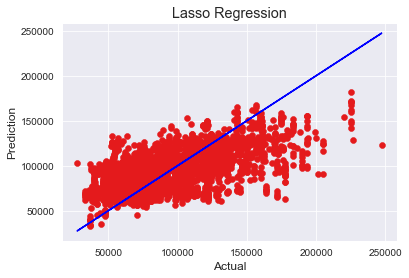

In [26]:
plt.scatter(y_test, lasso_grid.best_estimator_.predict(X_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('Lasso Regression')

plt.show()

No improvement. Let's move on to XGBoost:

# XGBoost

In [27]:
xgb_r = xg.XGBRegressor(objective ='reg:squarederror', 
                  n_estimators = 100, seed = 123)
xgb_r.fit(X_train,y_train)

mean_absolute_error(y_test, xgb_r.predict(X_test))

21238.198411777026

Now let's do some tuning:

In [28]:
params= {'n_estimators': [100, 1000],
    'learning_rate': [0.01,0.1,0.5,0.9],
    'max_depth': [10, 100, None]}

xgb_grid = xg.XGBRegressor(objective ='reg:squarederror', seed = 123)
xgb_grid = GridSearchCV(xgb_grid, params, cv=2, verbose=2, n_jobs = -1)
xgb_grid.fit(X_train,y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  42 out of  48 | elapsed:  2.2min remaining:   18.8s
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.9min finished


GridSearchCV(cv=2,
             estimator=XGBRegressor(objective='reg:squarederror', seed=123),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 0.9],
                         'max_depth': [10, 100, None],
                         'n_estimators': [100, 1000]},
             verbose=2)

In [29]:
print(xgb_grid.best_params_)
print(xgb_grid.best_estimator_.score(X_test,y_test))
print(xgb_grid.best_estimator_)

{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 1000}
0.3772982674665495
XGBRegressor(learning_rate=0.01, max_depth=10, n_estimators=1000,
             objective='reg:squarederror', seed=123)


In [30]:
mean_absolute_error(y_test, xgb_grid.best_estimator_.predict(X_test))

21048.844890461103

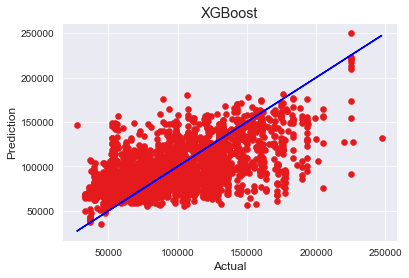

In [31]:
plt.scatter(y_test, xgb_grid.best_estimator_.predict(X_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('XGBoost')

plt.show()

RandomForest is still in the lead.

Now let's try LinearRegression:

# LinearRegression

In [32]:
reg = LinearRegression().fit(X_train,y_train)
mean_absolute_error(y_test, reg.predict(X_test))

21749.525495337995

As expected, it is not good. Let's create a pipeline and use SelectKBest to apply GridSearchCV and see if our model improves:

In [33]:
pipe = make_pipeline(
    SelectKBest(f_classif),
    LinearRegression()
)

In [34]:
k = [k+1 for k in range(len(X_train.columns))]
grid_params = {'selectkbest__k': k}

lr_random = GridSearchCV(pipe, param_grid=grid_params, cv=3, n_jobs=-1)

lr_random.fit(X_train, y_train)

D:\Desktop\Springboard_Data_Science\Enviroments\pandas-profiling\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:116: RuntimeWarning: divide by zero encountered in true_divide
  f = msb / msw


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('selectkbest', SelectKBest()),
                                       ('linearregression',
                                        LinearRegression())]),
             n_jobs=-1,
             param_grid={'selectkbest__k': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                            12, 13, 14, 15, 16, 17, 18, 19, 20,
                                            21, 22, 23, 24, 25, 26, 27, 28, 29,
                                            30, ...]})

In [35]:
lr_random.best_estimator_.score(X_test,y_test)

0.3856575147715846

In [36]:
mean_absolute_error(y_test, lr_random.best_estimator_.predict(X_test))

21696.776745849194

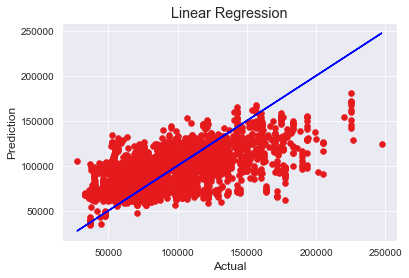

In [37]:
plt.scatter(y_test, lr_random.best_estimator_.predict(X_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('Linear Regression')

plt.show()

It improved a little bit, but not enough to be better than RF.

Let's explore OLS:

# OLS

In [38]:
X = df.drop('Avg_Salary', axis=1)
y = df.Avg_Salary
X_sm = sm.add_constant(X)
XOLS_train, XOLS_test, yOLS_train, yOLS_test = train_test_split(X_sm, y, test_size=0.3, random_state=42)
model = sm.OLS(yOLS_train, XOLS_train)
model = model.fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Avg_Salary   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     43.29
Date:                Thu, 25 Feb 2021   Prob (F-statistic):               0.00
Time:                        12:22:51   Log-Likelihood:                -93210.
No. Observations:                8008   AIC:                         1.867e+05
Df Residuals:                    7887   BIC:                         1.875e+05
Df Model:                         120                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                7.66e+04   3417.602     22.414      0.000    6.99e+04    8.33e+04
R                                    277.9529    941.206      0.295      0.768   -1567.061    2122.967
Python                              2958.6309    859.148      3.444      0.001    1274.473    4642.789
Julia                               4451.2037   5622.626      0.792      0.429   -6570.632    1.55e+04
SQL                                 1570.0485    714.628      2.197      0.028     169.188    2970.909
Scala                                -96.8009    943.290     -0.103      0.918   -1945.900    1752.298
JavaScript                         -1350.9833   1704.778     -0.792      0.428   -4692.800    1990.834
Title_Machine                       8478.0060   2161.298      3.923      0.000    4241.289    1.27e+04
Title_Deep                         -8107.3792   8825.840     -0.919      0.358   -2.54e+04    9193.605
Title_Analyst                      -2.148e+04   1290.201    -16.650      0.000    -2.4e+04    -1.9e+04
Title_Engineer                      1855.6817   1379.500      1.345      0.179    -848.503    4559.867
Title_Scientist                     9522.3870   1334.761      7.134      0.000    6905.902    1.21e+04
Title_Manager                       -679.3220   2372.909     -0.286      0.775   -5330.852    3972.208
Title_Senior                        3199.4264    864.851      3.699      0.000    1504.089    4894.764
Title_Junior                       -3516.0720   2534.145     -1.387      0.165   -8483.668    1451.524
Title_Lead                          3455.0226   2031.753      1.701      0.089    -527.752    7437.797
Title_Principal                     6807.9666   2577.306      2.642      0.008    1755.765    1.19e+04
Title_Chief                         4959.3704   9893.485      0.501      0.616   -1.44e+04    2.44e+04
Title_Intern                        4673.0768   4326.897      1.080      0.280   -3808.787    1.32e+04
Employer_Estimate                   2.575e+04   3611.271      7.129      0.000    1.87e+04    3.28e+04
Size_ord                            -874.0008    393.912     -2.219      0.027   -1646.173    -101.829
Revenue_ord                          483.7907    216.789      2.232      0.026      58.827     908.755
Rating                              1471.3491    565.715      2.601      0.009     362.398    2580.301
AZ                                  9632.4067   4314.930      2.232      0.026    1174.002    1.81e+04
CA                                  2.996e+04   2579.558     11.615      0.000    2.49e+04     3.5e+04
CO                                  8129.2108   3995.982      2.034      0.042     296.028     1.6e+04
DC                                  1958.8614   1831.601      1.069      0.285   -1631.562    55

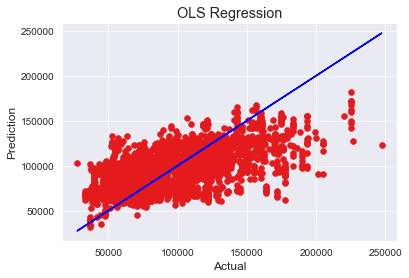

In [39]:
plt.scatter(yOLS_test, model.predict(XOLS_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('OLS Regression')
plt.show()

### Dumping Cities, States and Companies

Let us try without most of the dummy variables to see what kind of results we get:

In [40]:
df_new = df.iloc[:,:22].copy()
df_new['Avg_Salary'] = df.Avg_Salary

In [41]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(df_new.drop('Avg_Salary', axis=1), df_new.Avg_Salary, test_size=0.30, random_state=42)

# RandomForest

In [42]:
rf_new = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_new.fit(X_train_new,y_train_new)
rf_new.score(X_test_new,y_test_new)

0.1246373612265026

In [43]:
mean_absolute_error(y_test_new, rf_new.predict(X_test_new))

25341.723969384766

In [44]:
params_grid = {'bootstrap': [True, False],
               'max_depth': [10, 100, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [5,50,100],
               'n_estimators': [100,1000]}
rf_grid_new = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_grid_new = GridSearchCV(rf_grid_new, params_grid, cv = 2, verbose=2, n_jobs = -1)

In [45]:
rf_grid_new.fit(X_train_new,y_train_new)

Fitting 2 folds for each of 72 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:   27.0s finished


GridSearchCV(cv=2, estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 100, None],
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [5, 50, 100],
                         'n_estimators': [100, 1000]},
             verbose=2)

In [46]:
print(rf_grid_new.best_params_)
print(rf_grid_new.best_estimator_.score(X_test_new,y_test_new))
print(rf_grid_new.best_estimator_)

{'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
0.2372322535800171
RandomForestRegressor(bootstrap=False, max_depth=10, max_features='sqrt',
                      min_samples_leaf=5, n_jobs=-1, random_state=42)


In [47]:
mean_absolute_error(y_test_new, rf_grid_new.best_estimator_.predict(X_test_new))

24277.64092400478

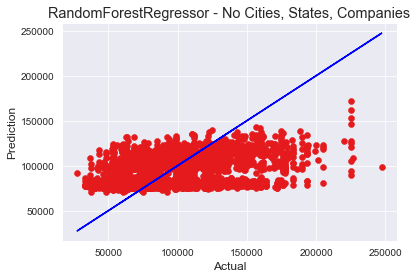

In [48]:
plt.scatter(y_test_new, rf_grid_new.best_estimator_.predict(X_test_new))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('RandomForestRegressor - No Cities, States, Companies')

plt.show()

#### Saving model:

In [51]:
import sklearn
best_model = rf_n
best_model.version = 1.0
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn.__version__
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

In [53]:
modelpath = 'salary_prediction_model.pkl'
pickle.dump(best_model, open(modelpath, 'wb'))

# Conclusions

 - Our best model ended up being a RandomForestRegressor.

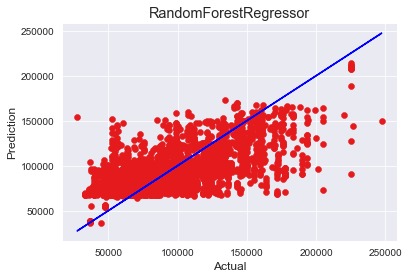

In [54]:
plt.scatter(y_test, rf_n.predict(X_test))
plt.plot(y_test, y_test, c='b')
plt.ylabel('Prediction')
plt.xlabel('Actual')
plt.title('RandomForestRegressor')

plt.show()

 - Our MAE is `$20941`. I believe this is due to our dataset. Most observation had a Glassdoor Estimate range with a difference greater than `$40K`, and, despite this, our model is able to reduce that range to slightly below `$42K`. 


#### Additional approac to take:
 - NLP can be applied to `Job_Desc` to try and find correlations with the actual text and the salary. We tried a version of this by extracting keywords such as `Python`, `R`, `Scala`, etc.
